# Angular Margin Loss Functions Comparison: ArcFace vs MV-Arc-Softmax vs CurricularFace



In [1]:
from abc import abstractmethod
import logging
import math
from pathlib import Path
import sys
from typing import Dict, List, Optional, Tuple

import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

np.random.seed(1234)
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
def setup_logger():
    logger = logging.getLogger('train')
    logger.setLevel(logging.INFO)
    if len(logger.handlers) == 0:
      formatter = logging.Formatter('%(asctime)s | %(message)s')
      ch = logging.StreamHandler(stream=sys.stdout)
      ch.setFormatter(formatter)
      logger.addHandler(ch)
      fh = logging.handlers.WatchedFileHandler("train.log")
      fh.setFormatter(formatter)
      logger.addHandler(fh)
    return logger

logger = setup_logger()


class SummaryWriter:
    def __init__(self, nrof_epochs: int, nrof_batchs: int) -> None:
        self.nrof_epochs = nrof_epochs
        self.nrof_batchs = nrof_batchs
        self.epoch = 0

    def set_epoch(self, epoch: int) -> None:
        self.epoch = epoch

    def __call__(self, mode: str, i_batch: int, metrics: Dict[str, float]) -> None:
        summary = f"{mode.title()} Epoch {self.epoch}/{self.nrof_epochs} | Batch {i_batch}/{self.nrof_batchs} | "
        for metric_name, metric_value in metrics.items():
            summary += f"{metric_name.title()} {metric_value:.2f} | "
        logger.info(summary[:-2])

In [3]:
class AngularMarginHead(nn.Module):
    def __init__(self, feature_size: int, nrof_classes:int, s: int, m: float, clip: Optional[bool]=True) -> None:
        super().__init__()
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.min_allowed = math.cos(math.pi - m)
        self.clip = clip

        self._cosine = None
        self.sine = None

        self.weight = nn.parameter.Parameter(torch.Tensor(nrof_classes, feature_size))
        nn.init.xavier_uniform_(self.weight)

    @property
    def cosine(self):
        return self._cosine

    @cosine.setter
    def cosine(self, value):
        self._cosine = value
        self.sine = torch.sqrt(1 - self.cosine**2)
    
    @abstractmethod
    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine similarity modulator 
        """

    @abstractmethod
    def negative_cosine_similarity_modulator(self, cosine_after_positive_modulator: torch.Tensor) -> torch.Tensor:
        """
        Negative cosine similarity modulator 
        """

    def forward(self, features: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        self.cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        if self.clip:
            self.cosine = torch.clip(self.cosine, self.min_allowed, 0.99)

        one_hot = torch.zeros_like(self.cosine).to(y.device)
        one_hot.scatter_(1, y.view(-1, 1).long(), 1)

        cosine_after_positive_modulator = self.positive_cosine_similarity_modulator()
        cosine_after_negative_modulator = self.negative_cosine_similarity_modulator(cosine_after_positive_modulator)

        output = torch.where(one_hot==1, cosine_after_positive_modulator, cosine_after_negative_modulator)
        return self.s*output


class ArcFace(AngularMarginHead):
    def __init__(self, feature_size: int, nrof_classes: int, s: Optional[int]=64, m: Optional[float]=0.5, clip: Optional[bool]=True) -> None:
        super().__init__(feature_size, nrof_classes, s, m, clip)
    
    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine modulator for ArcFace is: T(cos(theta)) = cos(theta + m),
        if we expand this expression it becomes: cos(theta)*cos(m) - sin(theta)*sin(m)
        """
        return self.cosine * self.cos_m - self.sine * self.sin_m

    def negative_cosine_similarity_modulator(self, cosine_after_positive_modulator: torch.Tensor) -> torch.Tensor:
        """
        There is no modulation for negative cosine similarity in ArcFace
        """
        return self.cosine


class MVArcSoftmax(AngularMarginHead):
    def __init__(self, feature_size: int, nrof_classes: int, s: Optional[int]=64, m: Optional[float]=0.5, t: Optional[float]=1.2, clip: Optional[bool]=True) -> None:
        super().__init__(feature_size, nrof_classes, s, m, clip)
        self.t = t
    
    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine modulator for MVArcSoftmax is: T(cos(theta_{y_i})) = cos(theta_{y_i} + m),
        if we expand this expression it becomes: cos(theta_{y_i})*cos(m) - sin(theta_{y_i})*sin(m)
        """
        return self.cosine * self.cos_m - self.sine * self.sin_m

    def negative_cosine_similarity_modulator(self, cosine_after_positive_modulator: torch.Tensor) -> torch.Tensor:
        """
        Negative cosine similarity modulator for MVArcSoftmax:

        if T(cos(theta_y_i)) - cos(theta_j) >= 0:
            return cos(theta_j)
        else:
            return t*cos(theta_j) + t - 1

        """
        return torch.where(cosine_after_positive_modulator - self.cosine >= 0, self.cosine, self.t*self.cosine + self.t - 1) 


class CurricularFace(AngularMarginHead):
    def __init__(self, feature_size:int, nrof_classes: int, s: Optional[int]=64, m: Optional[float]=0.5, alpha: Optional[float]=0.99, clip: Optional[bool]=True) -> None:
        super().__init__(feature_size, nrof_classes, s, m, clip)
        self.t = 0
        self.ts = []
        self.alpha = alpha
    
    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine modulator for CurricularFace is: T(cos(theta)) = cos(theta + m),
        if we expand this expression it becomes: cos(theta)*cos(m) - sin(theta)*sin(m)
        """
        return self.cosine * self.cos_m - self.sine * self.sin_m

    def negative_cosine_similarity_modulator(self, cosine_after_positive_modulator: torch.Tensor) -> torch.Tensor:
        """
        Negative cosine similarity modulator for CurricularFace:

        if T(cos(theta_y_i)) - cos(theta_j) >= 0:
            return cos(theta_j)
        else:
            return cos(theta_j) * (t + cos(theta_j))

        """
        return torch.where(cosine_after_positive_modulator - self.cosine >= 0, self.cosine, self.cosine**2 + self.t*self.cosine) 

    @torch.no_grad()
    def adjust_t(self, y: torch.Tensor) -> None:
        """
        We adjust t based on Exponential Moving Avarage 
        """
        r = self.cosine[torch.arange(len(self.cosine)), y].mean()
        self.t = self.alpha * r + (1 - self.alpha) * self.t

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        self.ts.append(self.t)
        output = super().forward(x, y)
        self.adjust_t(y)
        return output


class SoftmaxHead(nn.Module):
    def __init__(self, feature_size: int, nrof_classes: int) -> None:
        super().__init__()
        self.linear = nn.Linear(feature_size, nrof_classes)

    # NOTE: labels put as a method parameter for consistency with other heads
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
        return self.linear(x)

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.flatten(x, 1)


class EmbeddingsModel(nn.Module):
    def __init__(self, feature_size: int) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5), 
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            Flatten(),
            nn.Linear(64*4*4, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, feature_size),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma: int=2, eps: float=1e-7) -> None:
        super().__init__()
        self.gamma = gamma
        self.eps = eps
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, y_pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        log_p = self.cross_entropy(y_pred, y)
        p = torch.exp(-log_p)
        loss = (1 - p) ** self.gamma * log_p
        return loss.mean()

In [6]:
def show_features(features: np.ndarray, labels: np.ndarray, title: str) -> None:
    if features.shape[1] > 3:
        pca = PCA(n_components=3)
        pca.fit(features)
        features = pca.transform(features)
    
    fig = figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
    ax = Axes3D(fig)

    phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
    x = np.sin(phi)*np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(phi)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    features = features / np.linalg.norm(features, axis=1).reshape(-1, 1)
    x1 = features[:, 0]
    x2 = features[:, 1]
    x3 = features[:, 2]

    colors = cm.rainbow(np.linspace(0, 1, np.unique(labels).size))
    colors = [colors[label] for label in labels]
    ax.scatter(x1, x2, x3, color=colors)

    for i in range(len(features)):
        ax.plot([0, features[i][0]], [0, features[i][1]], zs=[0, features[i][2]], color=colors[i], alpha=0.1)

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    plt.show()


@torch.no_grad()
def plot_positive_cosine_distribution(loader: DataLoader, backbone: nn.Module, head: nn.Module) -> None:
    positive_thetas = []
    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)

        embeddings = backbone(x)
        logits = head(embeddings, y)

        positive_cosines = head.cosine[torch.arange(len(head.cosine)), y]
        positive_thetas.append(torch.arccos(positive_cosines))

    positive_thetas = np.degrees(torch.cat(positive_thetas).cpu().numpy())

    figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
    plt.hist(positive_thetas, bins=[theta for theta in range(60, 110)])
    plt.show()


@torch.no_grad()
def calculate_accuracy(logits: torch.Tensor, y: torch.Tensor) -> float:
    y_pred = torch.argmax(logits, dim=1)
    return torch.mean((y_pred==y).float()).item()


def pass_epoch(
    loader: DataLoader, 
    backbone: nn.Module, 
    head: nn.Module,
    optimizer: optim.Optimizer, 
    loss_fn: nn.Module, 
    summary_writer: SummaryWriter, 
    log_interval: int, 
    device: str
) -> Tuple[float]:

    loss = 0
    acc = 0
    with torch.set_grad_enabled(backbone.training):
        for i_batch, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)
    
            embeddings = backbone(x)
            logits = head(embeddings, y)
    
            loss_batch = loss_fn(logits, y)
            acc_batch = calculate_accuracy(logits, y)
    
            if backbone.training:
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
    
            loss_batch = loss_batch.item()
            if i_batch % log_interval == 0:
                mode = "train" if backbone.training else "validation"
                summary_writer(mode, i_batch, {"loss": loss_batch, "acc": acc_batch})
    
            loss += loss_batch
            acc += acc_batch

    loss /= (i_batch + 1)
    acc /= (i_batch + 1)
    return loss, acc


def train(
    train_loader: DataLoader, 
    validation_loader: DataLoader,
    head: nn.Module, 
    loss_fn: nn.Module,
    feature_size: int, 
    lr: float, 
    nrof_epochs: int, 
    log_interval: int,
    early_stop_after: int,
    device: str
) -> nn.Module:

    backbone = EmbeddingsModel(feature_size)
    backbone.to(device)
    head.to(device)

    backbone_state_dict = backbone.state_dict()
    head_state_dict = head.state_dict()

    optimizer = optim.Adam(list(backbone.parameters()) + list(head.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
    summary_writer = SummaryWriter(nrof_epochs, len(train_loader))

    max_acc = -1
    for epoch in range(nrof_epochs):
        summary_writer.set_epoch(epoch+1)
 
        backbone.train()
        head.train()
        loss, acc = pass_epoch(train_loader, backbone, head, optimizer, loss_fn, summary_writer, log_interval, device)
        logger.info(f"Train Epoch Loss: {loss:.2f} | Accuracy: {acc:.2f}\n")

        backbone.eval()
        head.eval()
        loss, acc = pass_epoch(validation_loader, backbone, head, optimizer, loss_fn, summary_writer, log_interval, device)
        acc = round(acc, 2)
        logger.info(f"Validation Epoch Loss: {loss:.2f} | Accuracy: {acc}\n")
 
        if acc > max_acc:
            max_acc = acc
            early_stop_counter = 0
            backbone_state_dict = backbone.state_dict()
            head_state_dict = head.state_dict()
        else:
            early_stop_counter += 1

        if early_stop_counter == early_stop_after or max_acc > 0.97:
            break
 
        scheduler.step(loss)
 
    backbone.load_state_dict(backbone_state_dict)
    head.load_state_dict(head_state_dict)
    return backbone, head, max_acc


@torch.no_grad()
def extract_embeddings(experiment_name: str, test_loader: DataLoader, backbone: nn.Module, device: str) -> Tuple[np.ndarray]:
    logger.info(f"Extracting embeddings with the model with: {experiment_name}")
    log_interval = len(test_loader)//5
    test_embeddings = []
    test_labels = []

    backbone.eval()
    for i_batch, (x, y) in enumerate(test_loader):
        x = x.to(device)

        test_embeddings.append(backbone(x))
        test_labels.append(y)

        if i_batch % log_interval == 0:
            logger.info(f"Extracting embedings Batch {i_batch}/{len(test_loader)}")
    
    return torch.cat(test_embeddings).cpu().numpy(), torch.cat(test_labels).numpy()

In [7]:
# Head parameters
m = 0.5 # For all
s = 64 # For all
alpha = 0.99 # For CurricularFace
t = 1.2 # For MV-Arc-Softmax

nrof_epochs = 50
batch_size = 512
lr = 5e-4
loss_fn_to_use = "softmax"
early_stop_after = 11
feature_size = 3 # Embeddings size
nrof_classes = 10 # MNIST has 10 classes
log_interval = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

transformations = transforms.Compose([
    transforms.ToTensor(), # NOTE: we might add some augmentations later on if we use a more challenging dataset
    transforms.Normalize(mean=0.485, std=0.229)
])

logger.info(f"Using device: {device}")

2021-01-13 17:26:20,297 | Using device: cuda


In [8]:
train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

train_dataset, validation_dataset = random_split(train_dataset, [50000, 10000])

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16,
    drop_last=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=16,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=16,
    drop_last=False
)

In [9]:
heads = {
    "softmax": SoftmaxHead(feature_size, nrof_classes),
    "arcface": ArcFace(feature_size, nrof_classes, s, m),
    "mv_arc_softmax": MVArcSoftmax(feature_size, nrof_classes, s, m, t),
    "curricular_face": CurricularFace(feature_size, nrof_classes, s, m, alpha)
}
loss_fns = {
    "softmax": nn.CrossEntropyLoss(),
    "focal": FocalLoss(),
}
loss_fn = loss_fns[loss_fn_to_use]

Let's train the model with all of the loss functions that are defined in this notebook, and compare their results

In [10]:
# head = CurricularFace(1000, 10, clip=False)
# head.to(device)
# head.train()
# 
# resnet50 = models.resnet50(pretrained=True)
# resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet50.to(device)
# resnet50.train()
# print("ResNet50 positive theta distribution at the beginning of the training")
# plot_positive_cosine_distribution(train_loader, resnet50, head)
# 
# resnet101 = models.resnet101(pretrained=True)
# resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet101.to(device)
# resnet101.train()
# print("ResNet101 positive theta distribution at the beginning of the training")
# plot_positive_cosine_distribution(train_loader, resnet101, head)
# 
# custom_model = EmbeddingsModel(1000)
# custom_model.to(device)
# custom_model.train()
# print("Custom model positive theta distribution at the beginning of the training")
# plot_positive_cosine_distribution(train_loader, custom_model, head)

2021-01-13 17:26:26,534 | Train Epoch 1/50 | Batch 0/97 | Loss 2.38 | Acc 0.07 
2021-01-13 17:26:27,894 | Train Epoch 1/50 | Batch 20/97 | Loss 1.60 | Acc 0.40 
2021-01-13 17:26:29,368 | Train Epoch 1/50 | Batch 40/97 | Loss 1.26 | Acc 0.49 
2021-01-13 17:26:30,849 | Train Epoch 1/50 | Batch 60/97 | Loss 1.06 | Acc 0.62 
2021-01-13 17:26:32,276 | Train Epoch 1/50 | Batch 80/97 | Loss 0.96 | Acc 0.65 
2021-01-13 17:26:32,942 | Train Epoch Loss: 1.32 | Accuracy: 0.51

2021-01-13 17:26:34,436 | Validation Epoch 1/50 | Batch 0/97 | Loss 0.86 | Acc 0.64 
2021-01-13 17:26:35,188 | Validation Epoch Loss: 0.85 | Accuracy: 0.66

2021-01-13 17:26:36,513 | Train Epoch 2/50 | Batch 0/97 | Loss 0.78 | Acc 0.69 
2021-01-13 17:26:38,389 | Train Epoch 2/50 | Batch 20/97 | Loss 0.69 | Acc 0.71 
2021-01-13 17:26:39,781 | Train Epoch 2/50 | Batch 40/97 | Loss 0.46 | Acc 0.88 
2021-01-13 17:26:41,218 | Train Epoch 2/50 | Batch 60/97 | Loss 0.42 | Acc 0.89 
2021-01-13 17:26:42,649 | Train Epoch 2/50 | Batc

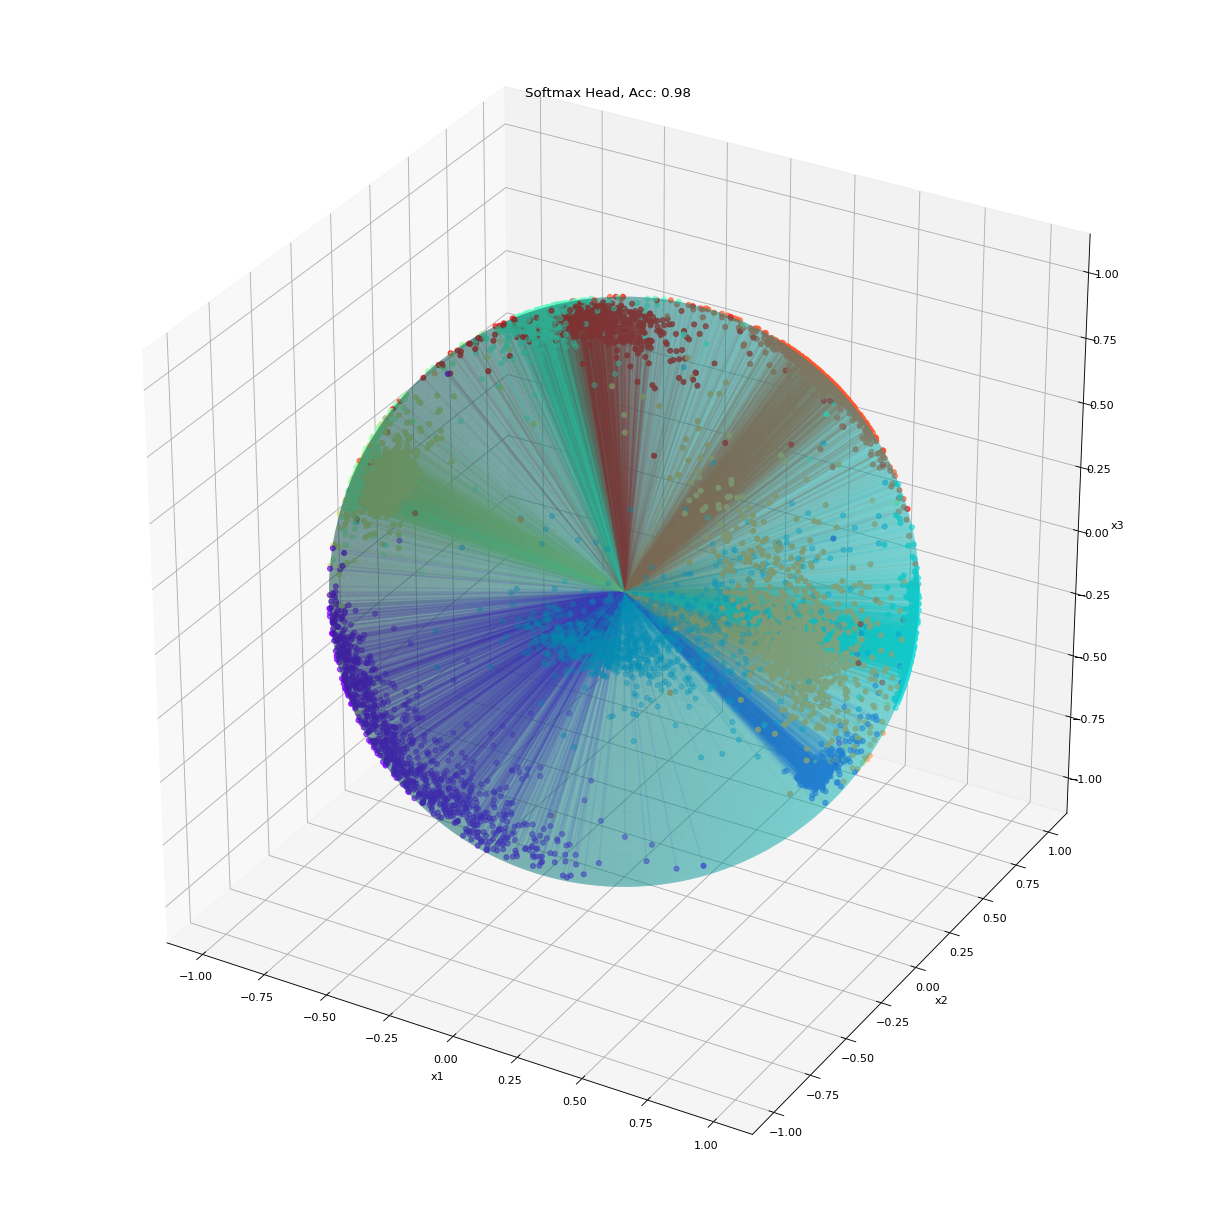

2021-01-13 17:27:51,607 | ------------------------------------------------------------

2021-01-13 17:27:53,350 | Train Epoch 1/50 | Batch 0/97 | Loss 74.33 | Acc 0.00 
2021-01-13 17:27:54,983 | Train Epoch 1/50 | Batch 20/97 | Loss 59.72 | Acc 0.00 
2021-01-13 17:27:56,554 | Train Epoch 1/50 | Batch 40/97 | Loss 31.30 | Acc 0.11 
2021-01-13 17:27:58,095 | Train Epoch 1/50 | Batch 60/97 | Loss 16.71 | Acc 0.26 
2021-01-13 17:27:59,689 | Train Epoch 1/50 | Batch 80/97 | Loss 9.41 | Acc 0.43 
2021-01-13 17:28:00,494 | Train Epoch Loss: 31.53 | Accuracy: 0.19

2021-01-13 17:28:02,129 | Validation Epoch 1/50 | Batch 0/97 | Loss 8.38 | Acc 0.46 
2021-01-13 17:28:02,891 | Validation Epoch Loss: 8.74 | Accuracy: 0.45

2021-01-13 17:28:04,551 | Train Epoch 2/50 | Batch 0/97 | Loss 8.90 | Acc 0.45 
2021-01-13 17:28:06,186 | Train Epoch 2/50 | Batch 20/97 | Loss 7.94 | Acc 0.48 
2021-01-13 17:28:07,747 | Train Epoch 2/50 | Batch 40/97 | Loss 5.76 | Acc 0.58 
2021-01-13 17:28:09,303 | Train Epoch

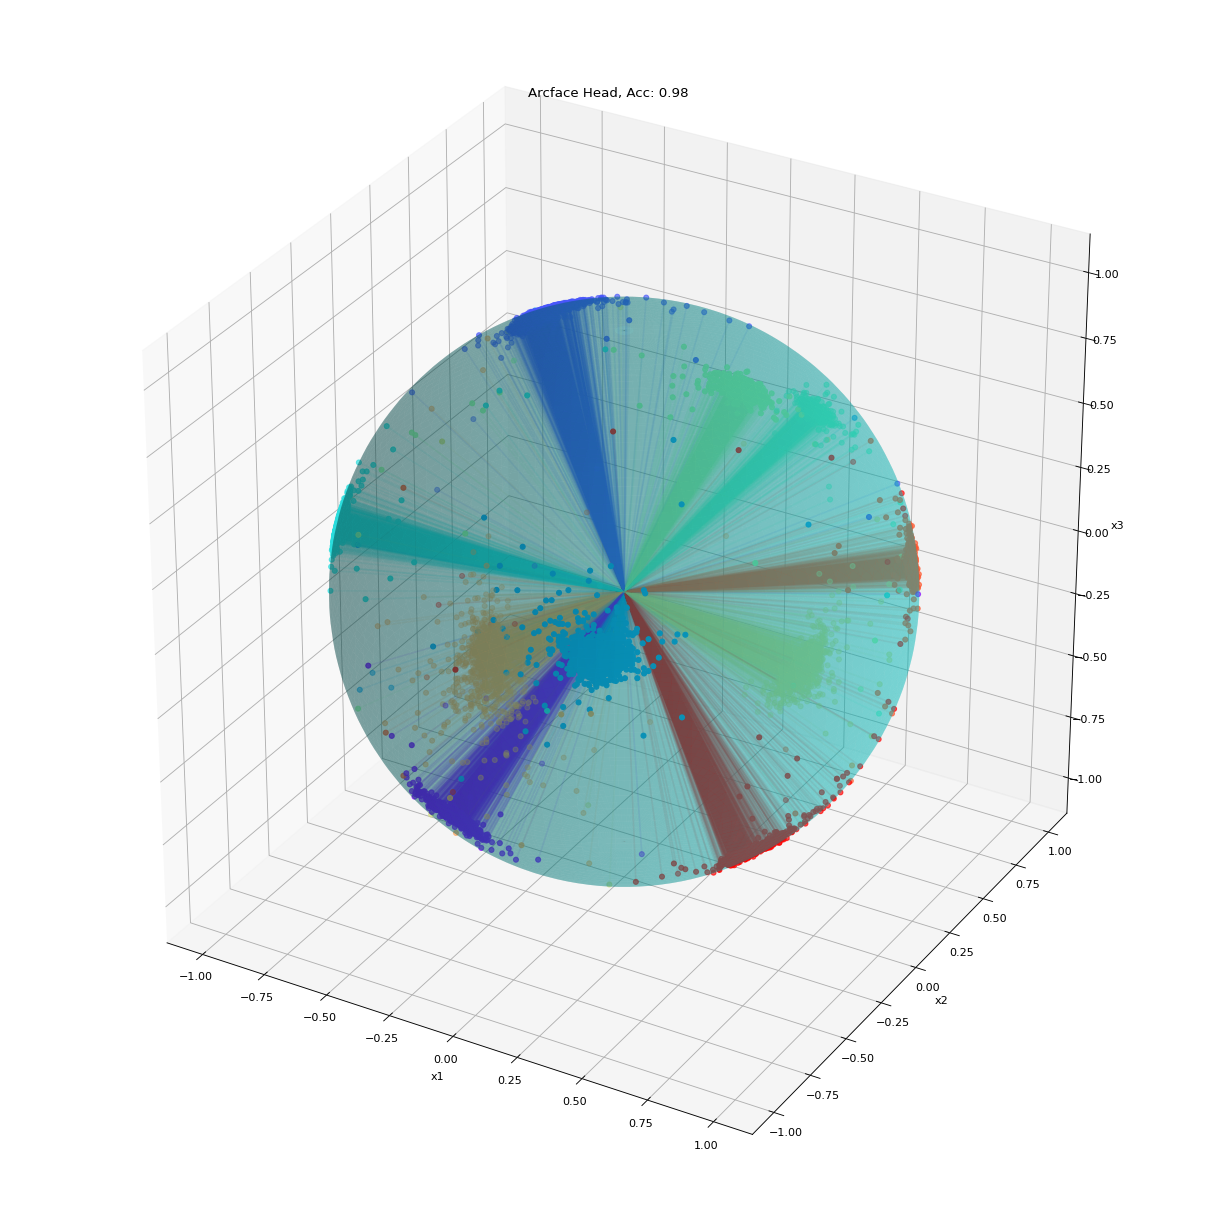

2021-01-13 17:31:10,195 | ------------------------------------------------------------

2021-01-13 17:31:11,983 | Train Epoch 1/50 | Batch 0/97 | Loss 80.79 | Acc 0.00 
2021-01-13 17:31:13,615 | Train Epoch 1/50 | Batch 20/97 | Loss 63.02 | Acc 0.00 
2021-01-13 17:31:15,059 | Train Epoch 1/50 | Batch 40/97 | Loss 62.27 | Acc 0.00 
2021-01-13 17:31:16,650 | Train Epoch 1/50 | Batch 60/97 | Loss 58.62 | Acc 0.00 
2021-01-13 17:31:18,132 | Train Epoch 1/50 | Batch 80/97 | Loss 58.35 | Acc 0.00 
2021-01-13 17:31:18,873 | Train Epoch Loss: 62.68 | Accuracy: 0.00

2021-01-13 17:31:20,558 | Validation Epoch 1/50 | Batch 0/97 | Loss 57.79 | Acc 0.00 
2021-01-13 17:31:21,284 | Validation Epoch Loss: 57.05 | Accuracy: 0.0

2021-01-13 17:31:22,804 | Train Epoch 2/50 | Batch 0/97 | Loss 56.18 | Acc 0.00 
2021-01-13 17:31:24,620 | Train Epoch 2/50 | Batch 20/97 | Loss 56.85 | Acc 0.00 
2021-01-13 17:31:26,201 | Train Epoch 2/50 | Batch 40/97 | Loss 40.31 | Acc 0.03 
2021-01-13 17:31:27,651 | Train 

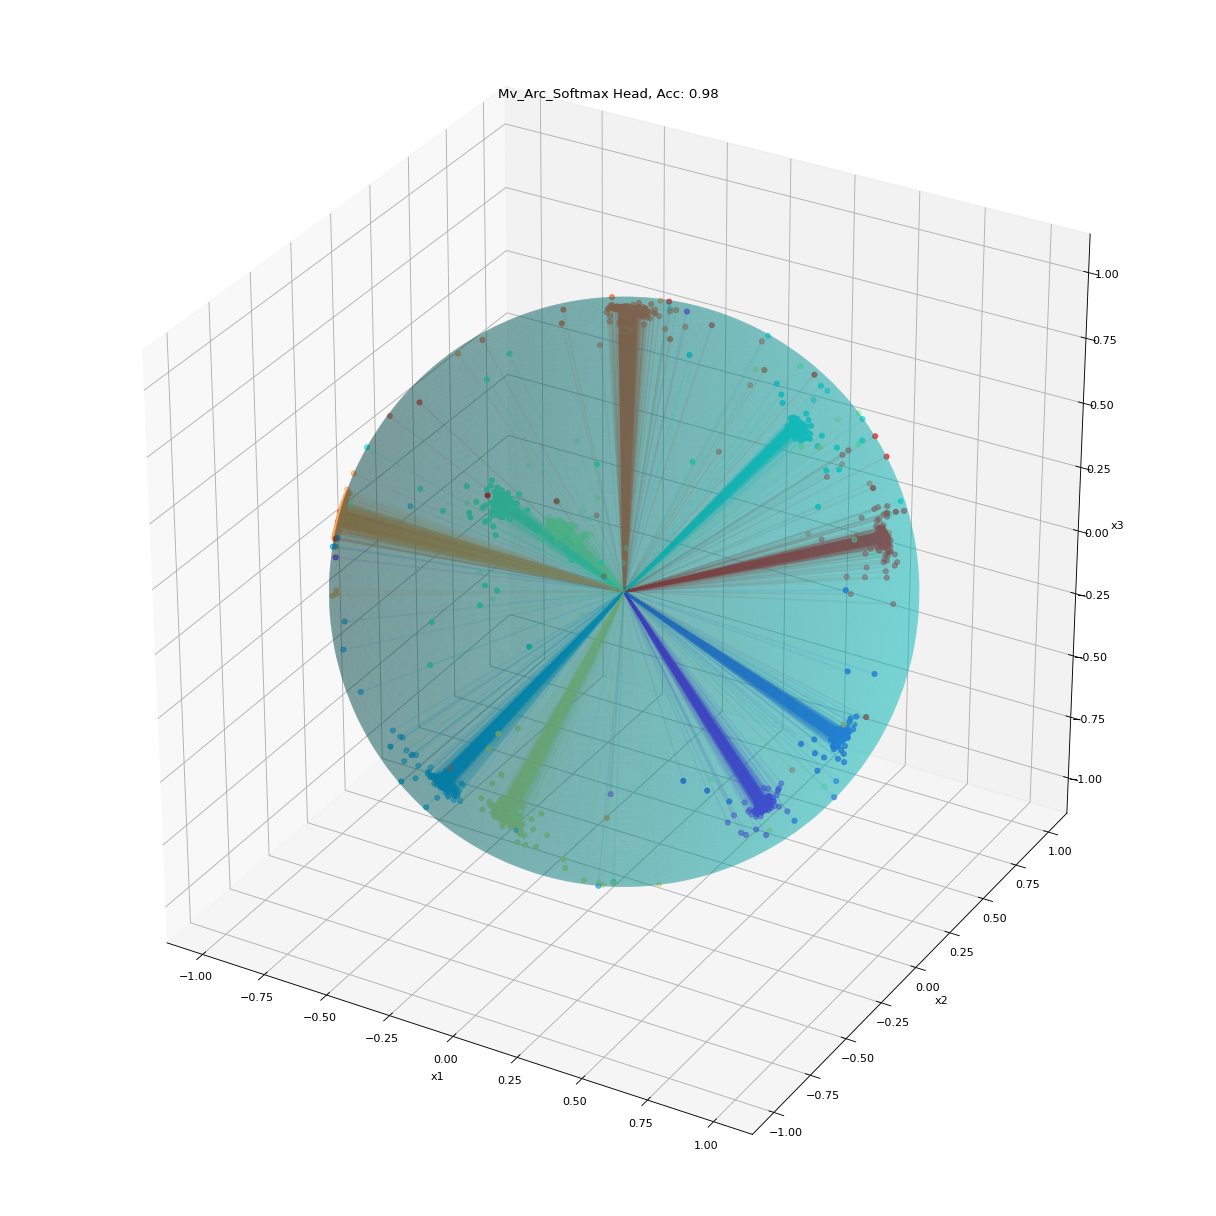

2021-01-13 17:35:34,009 | ------------------------------------------------------------

2021-01-13 17:35:41,871 | Train Epoch 1/50 | Batch 0/97 | Loss 79.72 | Acc 0.02 
2021-01-13 17:35:43,202 | Train Epoch 1/50 | Batch 20/97 | Loss 55.87 | Acc 0.00 
2021-01-13 17:35:44,728 | Train Epoch 1/50 | Batch 40/97 | Loss 49.21 | Acc 0.00 
2021-01-13 17:35:46,285 | Train Epoch 1/50 | Batch 60/97 | Loss 48.94 | Acc 0.00 
2021-01-13 17:35:47,589 | Train Epoch 1/50 | Batch 80/97 | Loss 45.85 | Acc 0.01 
2021-01-13 17:35:48,254 | Train Epoch Loss: 50.83 | Accuracy: 0.00

2021-01-13 17:35:49,896 | Validation Epoch 1/50 | Batch 0/97 | Loss 47.93 | Acc 0.01 
2021-01-13 17:35:50,630 | Validation Epoch Loss: 46.38 | Accuracy: 0.01

2021-01-13 17:35:52,449 | Train Epoch 2/50 | Batch 0/97 | Loss 44.49 | Acc 0.02 
2021-01-13 17:35:54,159 | Train Epoch 2/50 | Batch 20/97 | Loss 46.55 | Acc 0.00 
2021-01-13 17:35:55,707 | Train Epoch 2/50 | Batch 40/97 | Loss 45.08 | Acc 0.07 
2021-01-13 17:35:57,265 | Train

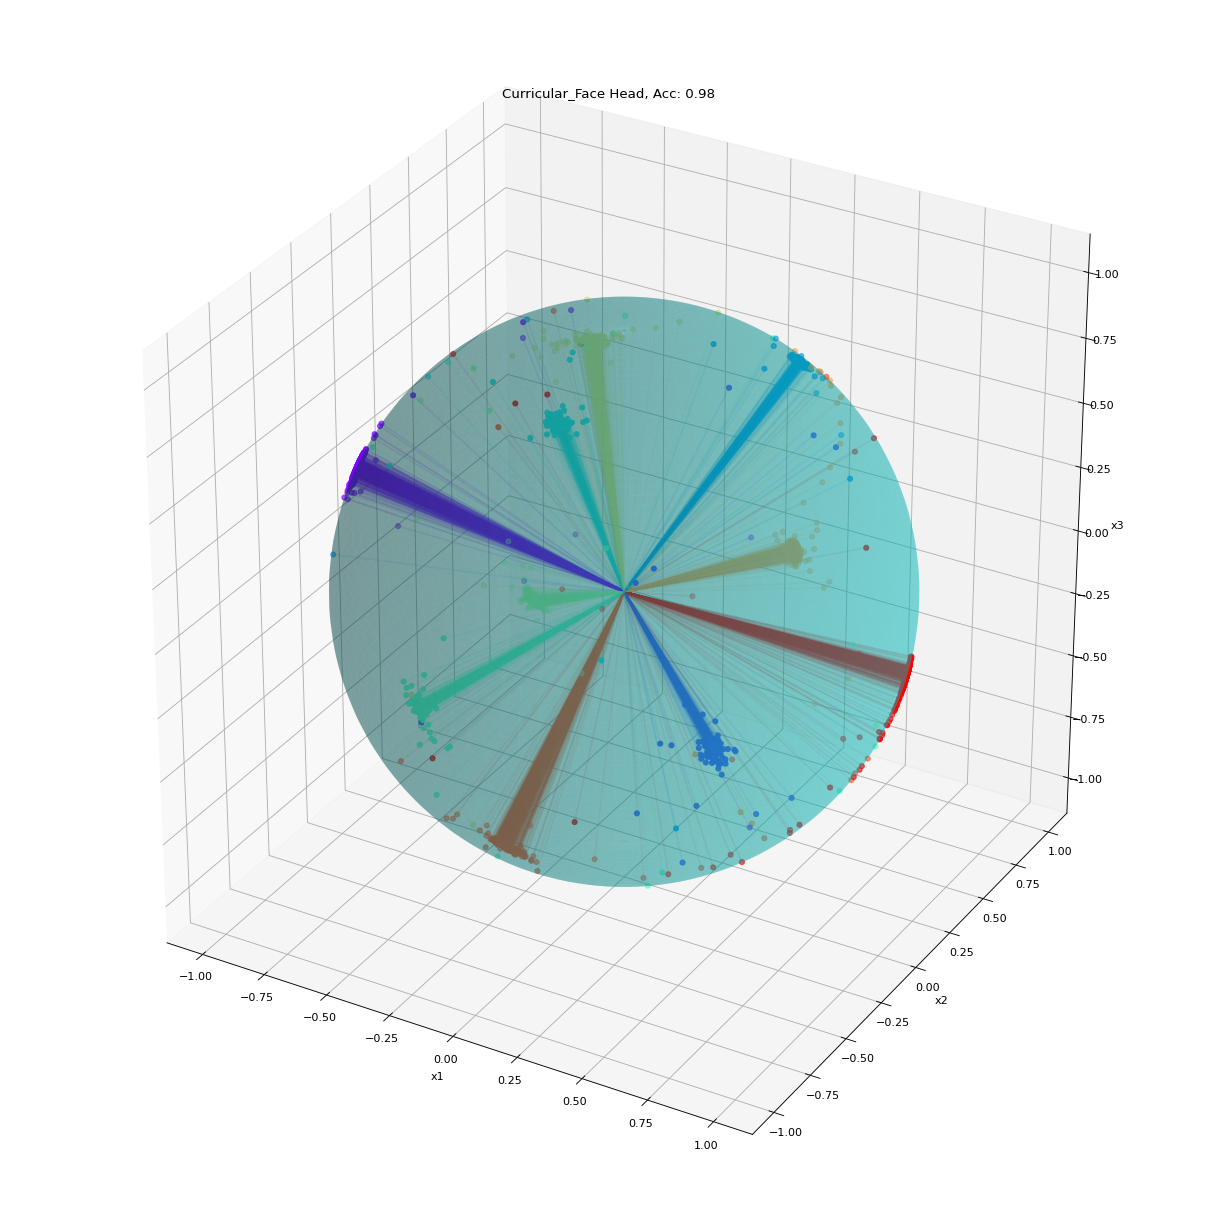

2021-01-13 17:41:11,289 | ------------------------------------------------------------



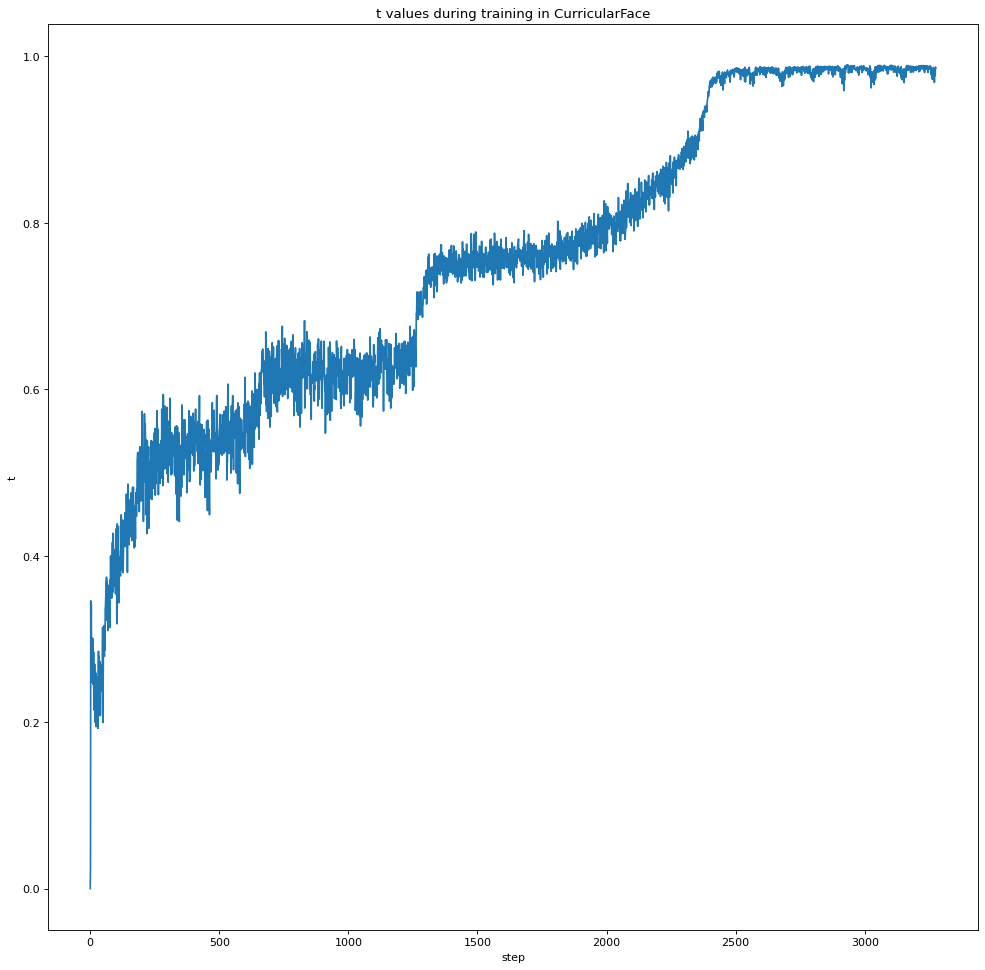

In [11]:
for head_name, head_model in heads.items():
    backbone, head, acc = train(
        train_loader, 
        validation_loader,
        head_model, 
        loss_fn, 
        feature_size, 
        lr, 
        nrof_epochs, 
        log_interval, 
        early_stop_after, 
        device
    )
    
    test_embeddings, test_labels = extract_embeddings(head_name.title(), test_loader, backbone, device)
    show_features(test_embeddings, test_labels, title=f"{head_name.title()} Head, Acc: {acc}")
    if head_name == "curricular_face":
        figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(head.ts)
        plt.title("t values during training in CurricularFace")
        plt.xlabel("step")
        plt.ylabel("t")
    logger.info(60*"-" + "\n")

In [12]:
from torchsummary import summary

In [13]:
summary(backbone, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
             PReLU-2           [-1, 32, 24, 24]               1
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,264
             PReLU-5             [-1, 64, 8, 8]               1
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
             PReLU-9                  [-1, 256]               1
           Linear-10                  [-1, 256]          65,792
            PReLU-11                  [-1, 256]               1
           Linear-12                    [-1, 3]             771
Total params: 381,063
Trainable params: 381,063
Non-trainable params: 0
-------------------------------